In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('df.csv')

print(df.head())

   ReceiverID    ActionType  NegoOutcome  \
0          32         Offer  FinalAccept   
1          31  Counteroffer  FinalAccept   
2          32  Counteroffer  FinalAccept   
3          31  Counteroffer  FinalAccept   
4          32      Question  FinalAccept   

                                             Content  Length  \
0  hey chris great working together competition h...    1778   
1  hey alex pleasure mine starters think importan...    1949   
2  hey chris thank response glad hear agree date ...     693   
3  hello alex think solid compromis settled willi...     452   
4  dear chris glad hear willing accept terms come...    1349   

   Word count of nego message  NegoOutcomeLabel  \
0                         309                 1   
1                         337                 1   
2                         123                 1   
3                          77                 1   
4                         249                 1   

                                    Filtere

In [2]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import pickle
# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Tokenize the text data
def tokenize_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    return inputs

# Apply tokenization to the 'Content' column
df['Tokenized_Content'] = df['Content'].apply(tokenize_text)

# Perform inference using the model
def get_embeddings(tokenized_text):
    with torch.no_grad():
        outputs = model(**tokenized_text)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Apply the model to get embeddings for each tokenized text
df['Embeddings'] = df['Tokenized_Content'].apply(get_embeddings)


# Save the DataFrame to a pickle file
with open('df_with_embeddings.pkl', 'wb') as f:
    pickle.dump(df, f)

# Optionally, save the DataFrame to a CSV file (without embeddings)
df.drop(columns=['Tokenized_Content', 'Embeddings']).to_csv('df_with_embeddings.csv', index=False)

# Display the DataFrame with embeddings
print(df.head())

2025-01-26 00:57:30.419861: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-26 00:57:30.466302: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 00:57:30.466344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 00:57:30.466374: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 00:57:30.476518: I tensorflow/core/platform/cpu_feature_g

   ReceiverID    ActionType  NegoOutcome  \
0          32         Offer  FinalAccept   
1          31  Counteroffer  FinalAccept   
2          32  Counteroffer  FinalAccept   
3          31  Counteroffer  FinalAccept   
4          32      Question  FinalAccept   

                                             Content  Length  \
0  hey chris great working together competition h...    1778   
1  hey alex pleasure mine starters think importan...    1949   
2  hey chris thank response glad hear agree date ...     693   
3  hello alex think solid compromis settled willi...     452   
4  dear chris glad hear willing accept terms come...    1349   

   Word count of nego message  NegoOutcomeLabel  \
0                         309                 1   
1                         337                 1   
2                         123                 1   
3                          77                 1   
4                         249                 1   

                                    Filtere

In [3]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Lade die DataFrame mit Embeddings aus der Pickle-Datei
with open('df_with_embeddings.pkl', 'rb') as f:
    df = pickle.load(f)

# Zielvariable (Label) und Features definieren
X = df['Embeddings'].tolist()  # Die BERT-Embeddings als Features
y = df['NegoOutcomeLabel']     # Die Zielvariable für Erfolg (1) oder keinen Erfolg (0)

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trainiere ein Klassifikationsmodell (z. B. RandomForest)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Teste das Modell
y_pred = clf.predict(X_test)

# Ergebnisse auswerten
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.7849223946784922

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.10      0.17       104
           1       0.79      0.99      0.88       347

    accuracy                           0.78       451
   macro avg       0.78      0.54      0.52       451
weighted avg       0.78      0.78      0.71       451



In [4]:
# Modellgenauigkeit auf Trainingsdaten
train_accuracy = clf.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.2f}")

# Modellgenauigkeit auf Testdaten
test_accuracy = clf.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 1.00
Test Accuracy: 0.78


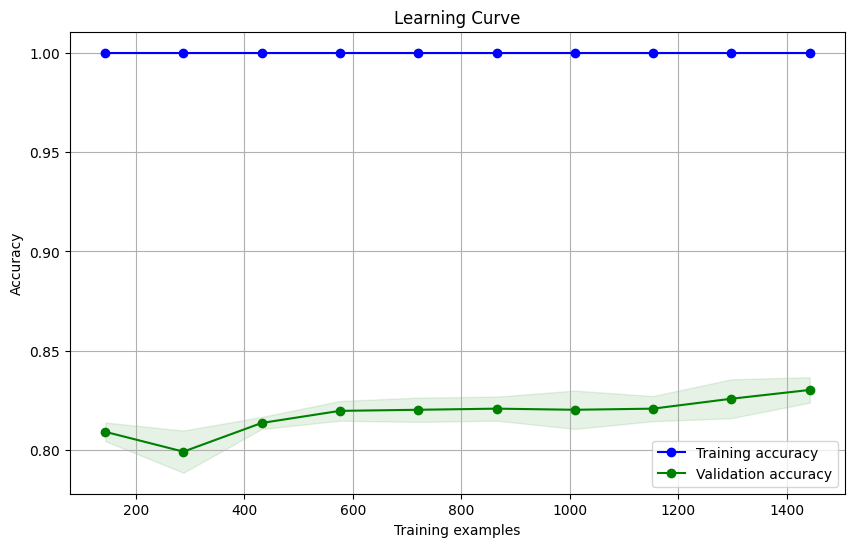

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Lernkurven erstellen
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

# Mittelwert und Standardabweichung der Scores berechnen
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Lernkurven plotten
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training accuracy")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()

In [9]:
from sklearn.model_selection import cross_val_score
# Cross-Validation mit 5 Folds
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

# Ergebnisse der Cross-Validation
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation of CV Accuracy: {np.std(cv_scores):.2f}")

# Optional: Trainiere das Modell auf dem gesamten Trainingsdatensatz
clf.fit(X, y)


Cross-Validation Scores: [0.80044346 0.85365854 0.77827051 0.7827051  0.82222222]
Mean CV Accuracy: 0.81
Standard Deviation of CV Accuracy: 0.03


RandomForestClassifier(random_state=42)

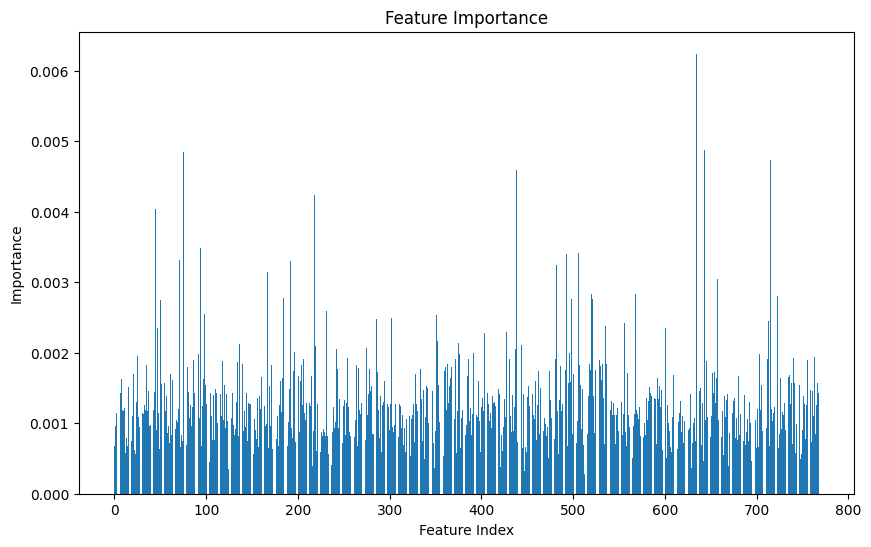

In [10]:
# Feature-Wichtigkeit extrahieren
importances = clf.feature_importances_

# Sortieren und visualisieren
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE  # SMOTE für Oversampling

# Lade die DataFrame mit Embeddings aus der Pickle-Datei
with open('df_with_embeddings.pkl', 'rb') as f:
    df = pickle.load(f)

# Zielvariable (Label) und Features definieren
X = df['Embeddings'].tolist()  # Die BERT-Embeddings als Features
y = df['NegoOutcomeLabel']     # Die Zielvariable für Erfolg (1) oder keinen Erfolg (0)

# Train-Test-Split (noch unausgeglichen)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Konvertiere die Features (Listen) in einen 2D-Array für SMOTE
import numpy as np
X_train = np.array(X_train)

# SMOTE anwenden, um die Klasse 0 zu oversamplen
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Optional: Überprüfe die neue Verteilung der Klassen
from collections import Counter
print("Class distribution after SMOTE:", Counter(y_train_resampled))

# Trainiere ein Klassifikationsmodell (z. B. RandomForest)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Teste das Modell
y_pred = clf.predict(X_test)

# Ergebnisse auswerten
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Class distribution after SMOTE: Counter({1: 1448, 0: 1448})
Model Accuracy: 0.7827050997782705

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.29      0.38       104
           1       0.81      0.93      0.87       347

    accuracy                           0.78       451
   macro avg       0.68      0.61      0.62       451
weighted avg       0.75      0.78      0.76       451



In [12]:
# Modellgenauigkeit auf Trainingsdaten
train_accuracy = clf.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.2f}")

# Modellgenauigkeit auf Testdaten
test_accuracy = clf.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 1.00
Test Accuracy: 0.78


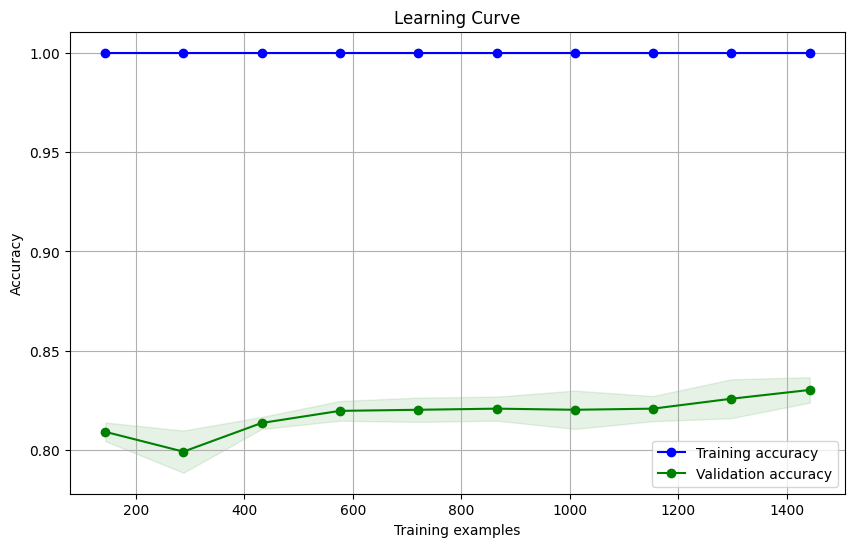

In [13]:
# Lernkurven erstellen
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

# Mittelwert und Standardabweichung der Scores berechnen
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Lernkurven plotten
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training accuracy")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()

In [14]:
from sklearn.model_selection import cross_val_score
# Cross-Validation mit 5 Folds
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

# Ergebnisse der Cross-Validation
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation of CV Accuracy: {np.std(cv_scores):.2f}")

# Optional: Trainiere das Modell auf dem gesamten Trainingsdatensatz
clf.fit(X, y)

Cross-Validation Scores: [0.80044346 0.85365854 0.77827051 0.7827051  0.82222222]
Mean CV Accuracy: 0.81
Standard Deviation of CV Accuracy: 0.03


RandomForestClassifier(random_state=42)

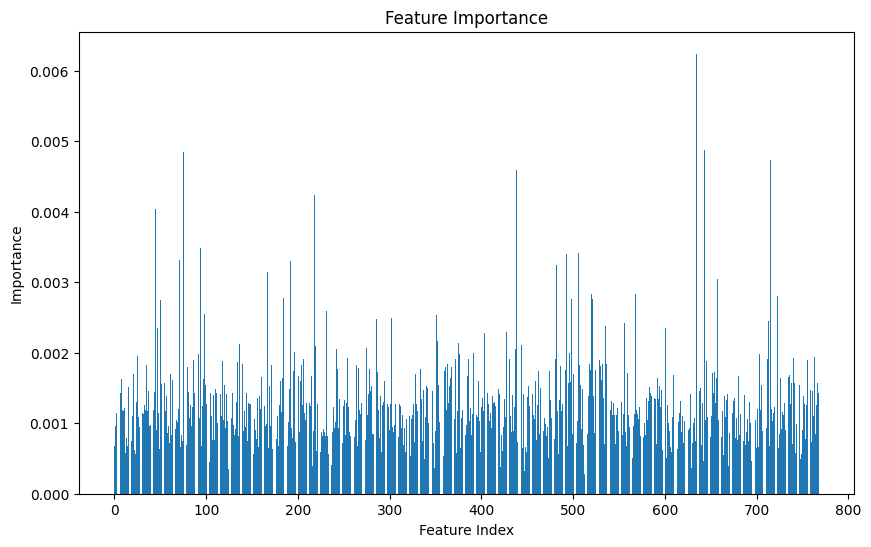

In [15]:
# Feature-Wichtigkeit extrahieren
importances = clf.feature_importances_

# Sortieren und visualisieren
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Lade die DataFrame mit Embeddings aus der Pickle-Datei
with open('df_with_embeddings.pkl', 'rb') as f:
    df = pickle.load(f)

# Zielvariable und BERT-Embeddings extrahieren
X_embeddings = df['Embeddings'].tolist()  # Die BERT-Embeddings als Features
y = df['NegoOutcomeLabel']  # Zielvariable (1 = Erfolg, 0 = Kein Erfolg)

# Feature Engineering: Zusätzliche Features aus dem Text (Content-Spalte)
df['Length'] = df['Content'].apply(len)  # Textlänge
df['Word count'] = df['Content'].apply(lambda x: len(x.split()))  # Wortanzahl


# Kombiniere alle Features: BERT-Embeddings + neue Features
X_additional = df[['Length', 'Word count'] ].values
X_embeddings = np.array(X_embeddings)
X_combined = np.hstack((X_embeddings, X_additional))  # Zusammenführen der Features

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# SMOTE anwenden, um den Datensatz auszugleichen
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# RandomForest-Modell trainieren
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Vorhersagen
y_pred = clf.predict(X_test)

# Ergebnisse auswerten
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.7694013303769401

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.26      0.34       104
           1       0.81      0.92      0.86       347

    accuracy                           0.77       451
   macro avg       0.65      0.59      0.60       451
weighted avg       0.74      0.77      0.74       451



In [17]:
# Modellgenauigkeit auf Trainingsdaten
train_accuracy = clf.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.2f}")

# Modellgenauigkeit auf Testdaten
test_accuracy = clf.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 1.00
Test Accuracy: 0.77


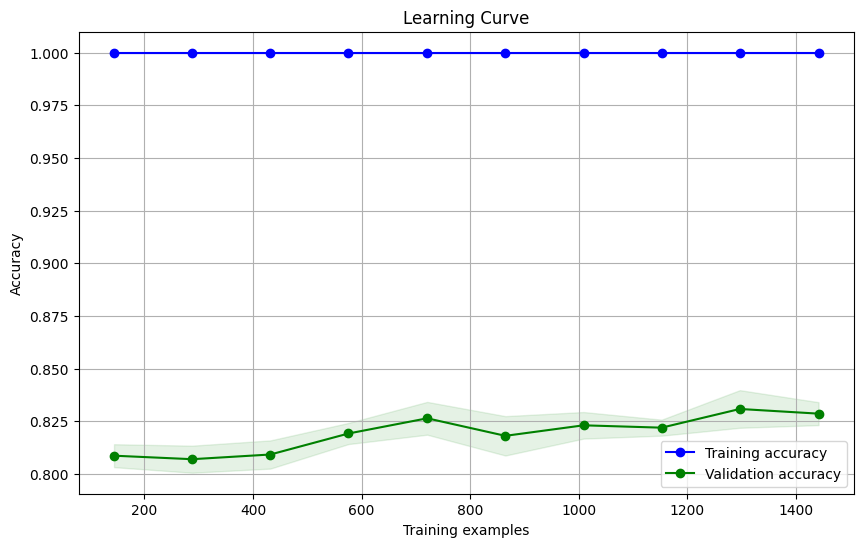

In [18]:
# Lernkurven erstellen
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

# Mittelwert und Standardabweichung der Scores berechnen
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Lernkurven plotten
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training accuracy")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()

In [19]:
from sklearn.model_selection import cross_val_score
# Cross-Validation mit 5 Folds
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

# Ergebnisse der Cross-Validation
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation of CV Accuracy: {np.std(cv_scores):.2f}")

# Optional: Trainiere das Modell auf dem gesamten Trainingsdatensatz
clf.fit(X, y)

Cross-Validation Scores: [0.80044346 0.85365854 0.77827051 0.7827051  0.82222222]
Mean CV Accuracy: 0.81
Standard Deviation of CV Accuracy: 0.03


RandomForestClassifier(random_state=42)

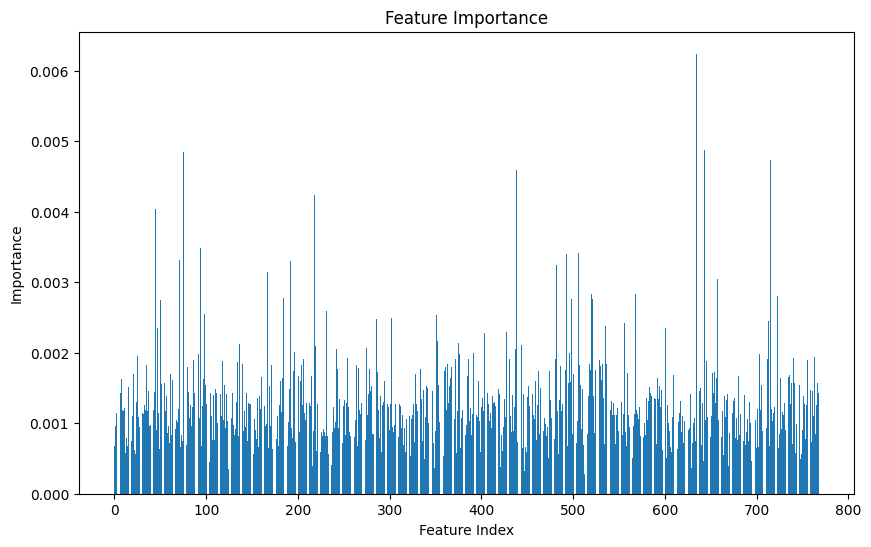

In [20]:
# Feature-Wichtigkeit extrahieren
importances = clf.feature_importances_

# Sortieren und visualisieren
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

In [21]:
from imblearn.over_sampling import RandomOverSampler

# Lade den DataFrame mit Embeddings aus der Pickle-Datei
with open('df_with_embeddings.pkl', 'rb') as f:
    df = pickle.load(f)

# Zielvariable und Features extrahieren
X = np.array(df['Embeddings'].tolist())  # Die BERT-Embeddings als Features
y = df['NegoOutcomeLabel']              # Die Zielvariable

# Funktion: Random Oversampling anwenden
def apply_random_oversampling(X, y):
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    print(f"Neue Klassenverteilung: {np.bincount(y_resampled)}")
    return X_resampled, y_resampled

# Random Oversampling anwenden
X_resampled, y_resampled = apply_random_oversampling(X, y)

# Optional: Trainiere ein Klassifikationsmodell mit den resampleten Daten
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Modell trainieren
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Vorhersagen
y_pred = clf.predict(X_test)

# Ergebnisse evaluieren
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Neue Klassenverteilung: [1795 1795]
Model Accuracy: 0.9777158774373259

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       355
           1       0.97      0.99      0.98       363

    accuracy                           0.98       718
   macro avg       0.98      0.98      0.98       718
weighted avg       0.98      0.98      0.98       718



In [22]:
# Modellgenauigkeit auf Trainingsdaten
train_accuracy = clf.score(X_train, y_train)
print(f"Train Accuracy: {train_accuracy:.2f}")

# Modellgenauigkeit auf Testdaten
test_accuracy = clf.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 1.00
Test Accuracy: 0.98


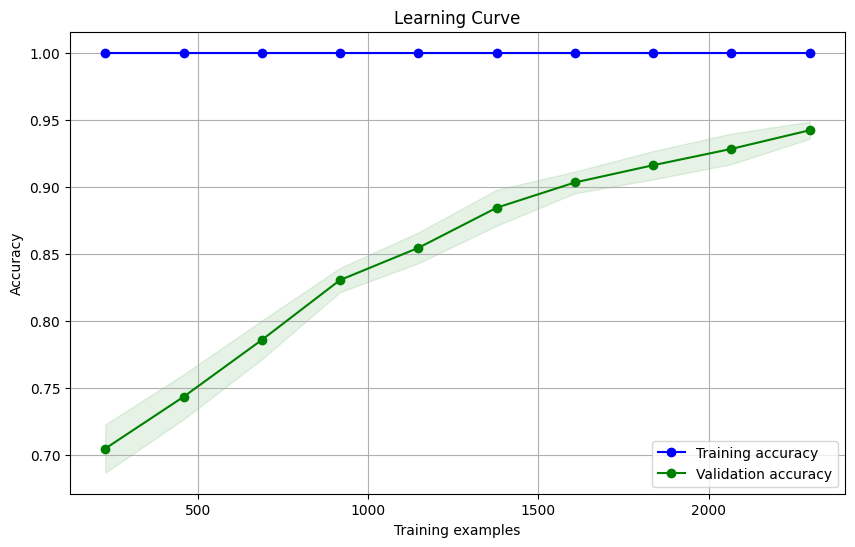

In [23]:
# Lernkurven erstellen
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

# Mittelwert und Standardabweichung der Scores berechnen
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Lernkurven plotten
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training accuracy")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Validation accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()

In [24]:
import numpy as np
from sklearn.model_selection import cross_val_score
# Cross-Validation mit 5 Folds
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

# Ergebnisse der Cross-Validation
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation of CV Accuracy: {np.std(cv_scores):.2f}")

# Optional: Trainiere das Modell auf dem gesamten Trainingsdatensatz
clf.fit(X, y)

Cross-Validation Scores: [0.80044346 0.85365854 0.77827051 0.7827051  0.82222222]
Mean CV Accuracy: 0.81
Standard Deviation of CV Accuracy: 0.03


RandomForestClassifier(random_state=42)

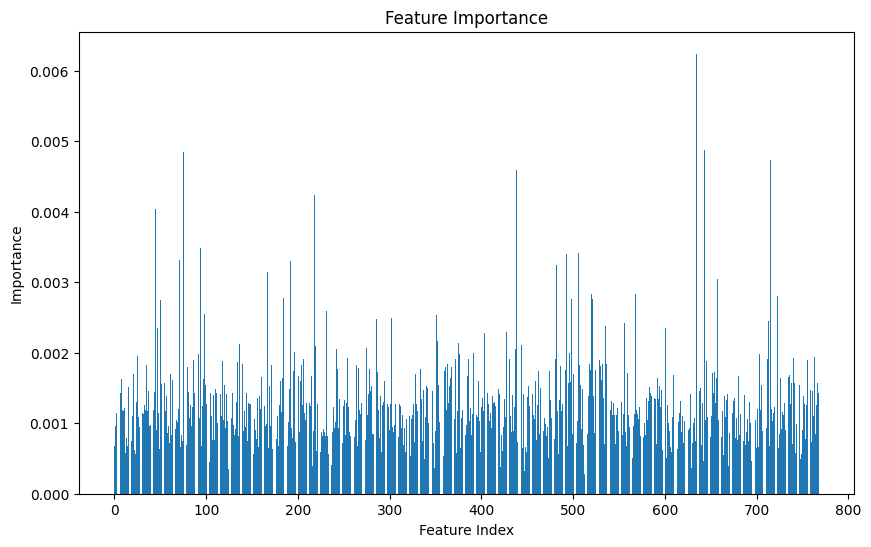

In [25]:
# Feature-Wichtigkeit extrahieren
importances = clf.feature_importances_

# Sortieren und visualisieren
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()